In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import statsmodels

framer = pd.DataFrame()
sns.set(style='white', context='paper')
matplotlib.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_columns', None)

In [40]:
#upload human skeletal muscle RNA seq data from GSE13205

muscle_rna = pd.read_csv('/Users/brooksleitner/Desktop/Python/sepsismetabolism/data/rna/humanmusclernaseq.csv')
individual_rna = pd.read_csv('/Users/brooksleitner/Desktop/Python/sepsismetabolism/data/rna/humanmusclernaseq_individualvalues.csv')
demographics = pd.read_csv('/Users/brooksleitner/Desktop/Python/sepsismetabolism/data/rna/human_muscle_demographics.csv')

In [41]:
#combine dataframes to perform filtering on both subsets

muscle_rna_summary = muscle_rna.merge(individual_rna, how='inner', on="Unnamed: 0")

In [42]:
#Get rid of rows where the gene is duplicated. This is common for microarray studies. We will keep the row that has the smaller p-value, which is the first value as the dataframe is currently sorted by adjusted p

muscle_rna_summary = muscle_rna_summary.drop_duplicates(subset='Gene.symbol', keep='first', inplace=False, ignore_index=False)

In [43]:
muscle_rna_summary = muscle_rna_summary[muscle_rna_summary['adj.P.Val'] < 0.05]

In [44]:
#Drop rows where there are multiple genes that the microarray chip could be coding for

muscle_rna_summary = muscle_rna_summary[muscle_rna_summary["Gene.symbol"].str.contains("///")==False]

In [45]:
#Make the dataframe with the essentials

muscle_rna_summary = muscle_rna_summary[['Gene.symbol', 'logFC', 'adj.P.Val', 'GSM333436' ,'GSM333437', 'GSM333438','GSM333439','GSM333440','GSM333441','GSM333442','GSM333443','GSM333444','GSM333445','GSM333446','GSM333447','GSM333448','GSM333449','GSM333450','GSM333451','GSM333452','GSM333453','GSM333454','GSM333455','GSM333456']]

In [46]:
muscle_rna_pathway_subsets = muscle_rna_summary

In [47]:
#Export gene list to create up- and down- regulated Enrichr plots

muscle_rna_summary.to_csv('/Users/brooksleitner/Desktop/Python/sepsismetabolism/data/rna/humanmusclerna_forenrichr.csv')

In [48]:
#Export gene list for PCA in R Jupyter Notebook
muscle_rna_summary_forPCA = muscle_rna_summary.drop(['logFC', 'adj.P.Val'], axis=1)

muscle_rna_summary_forPCA.to_csv('/Users/brooksleitner/Desktop/Python/sepsismetabolism/data/rna/musclerna_forPCA.csv')

# Clustermap

In [49]:
#Change the name of the dataframe so that we can modify it for this purpose
muscle_rna_summary_clustermap = muscle_rna_summary

In [50]:
#Add Gene Sets for labels on clustermap for:
#1. Glutathione Metabolism (KEGG Glutathione)
#2. Amino Acid Metabolism (metabolic superpathways list)
#3. Glucose Metabolism (metabolic superpathways list)
#4. TCA Cycle (metabolic superpathways list)
#5. Redox (GO Cellular Redox State)
#6. Energy Metabolism (metabolic superpathways list)

#Upload metabolic gene lists
#data obtained unaltered from supplemental table 2 of DOI:https://doi.org/10.1016/j.celrep.2018.03.077, then additions for Glutathione and Redox from MSIGDB

data = "/Users/brooksleitner/Desktop/Python/sepsismetabolism/data/rna/genelists/metabolicsuperpathwaygenelist.xlsx"
aminoacids = pd.read_excel(data, sheet_name=0, header=1)
carbohydrates = pd.read_excel(data, sheet_name=1, header=1)
energy = pd.read_excel(data, sheet_name=2, header=1)
lipid = pd.read_excel(data, sheet_name=3, header=1)
nucleotide = pd.read_excel(data, sheet_name=4, header=1)
tca = pd.read_excel(data, sheet_name=5, header=1)
vitamin = pd.read_excel(data, sheet_name=6, header=1)
glutathione = pd.read_excel(data, sheet_name=7, header=1)
redox = pd.read_excel(data, sheet_name=8, header=1)

human_muscle_gene_pathways = aminoacids.append([carbohydrates, energy, tca, glutathione, redox])


In [51]:
#Drop gene duplicates

human_muscle_gene_pathways = human_muscle_gene_pathways.drop_duplicates(subset='Genes', keep='last', inplace=False, ignore_index=False)

In [52]:
#Merge the Genes with the full dataset
#We need Gene Name, Pathway, and individual values
#Then we will set the Gene Name to the Index and pop the pathway name for clustermap

muscle_rna_summary_clustermap = muscle_rna_summary_clustermap.drop(['logFC', 'adj.P.Val'], axis=1)
muscle_rna_summary_clustermap = muscle_rna_summary_clustermap.rename(columns = {'Gene.symbol':'Genes'})

muscle_rna_summary_clustermap = muscle_rna_summary_clustermap.merge(human_muscle_gene_pathways, how='inner', on="Genes")

muscle_rna_summary_clustermap.set_index('Genes', inplace = True)

pathway = muscle_rna_summary_clustermap.pop('Pathway')


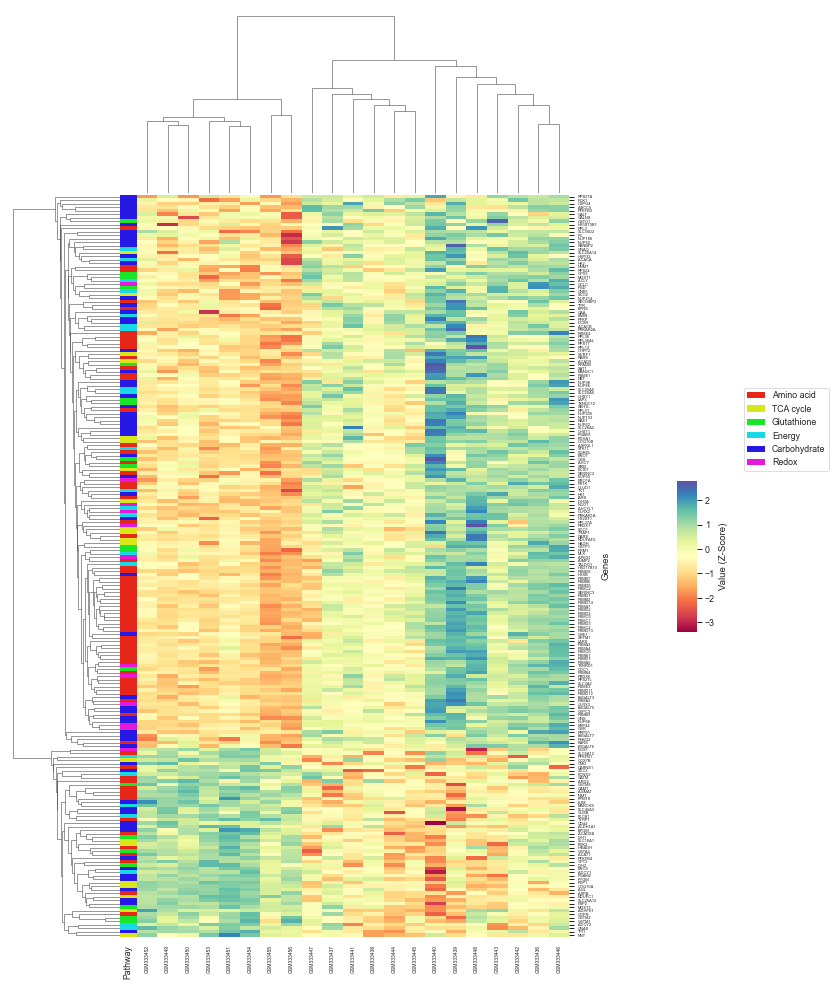

In [53]:
lut = dict(zip(pathway.unique(), sns.hls_palette(len(set(pathway)), l=0.5, s=0.8)))
row_colors = pathway.map(lut)
g = sns.clustermap(muscle_rna_summary_clustermap, z_score=0, figsize=(9, 14),
                   cbar_pos=(1.05, 0.37, .03, 0.15),
                   cbar_kws={"label" : "Value (Z-Score)"},
                   row_colors=row_colors, cmap='Spectral',
                   yticklabels=True)
for label in pathway.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(bbox_to_anchor=(1.6, -1.5), loc='lower right', borderaxespad=0, ncol=1)
plt.rcParams['pdf.fonttype'] = 42
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 4)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 5)

g.savefig('/Users/brooksleitner/Desktop/Python/sepsismetabolism/figures/rna/HumanMuscle_RNA_MetabolismClustermap.svg', bbox_inches="tight", dpi=300)

# Volcano

In [54]:
#Create three significance categories: Not Significant (bh_p >0.05, Significantly Upregulated bh_p < 0.05 & log2FC > 0, Significantly downregulated, bh_p < 0.05 & log2FC < 0)

#Change name of dataframe so we can modify for this purpose
muscle_rna_summary_volcano = muscle_rna_summary

def condition_setting(logfc, adjusted_p):
    if logfc > 0 and adjusted_p < 0.05:
        condition = 'Significantly Upregulated'
    elif logfc < 0 and adjusted_p < 0.05:
        condition = 'Significantly Downregulated'
    else:
        condition = 'Not Significant'
    return condition

muscle_rna_summary_volcano['Significance'] = muscle_rna_summary_volcano.apply(lambda x: condition_setting(x['logFC'], x['adj.P.Val']), axis=1)

In [55]:
#invert p value for Volcano plot

muscle_rna_summary_volcano['logadjP_for_volcano'] = -(np.log2(muscle_rna_summary_volcano['adj.P.Val']))

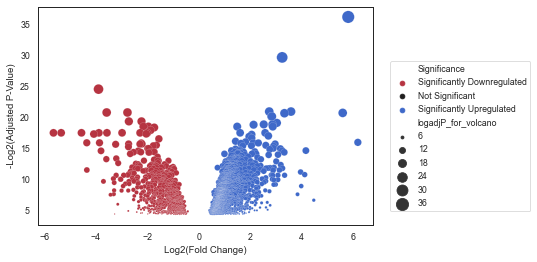

In [56]:
#Volcano Plot

#Try a Seaborn Scatterplot
g = sns.scatterplot(data=muscle_rna_summary_volcano, x="logFC", y="logadjP_for_volcano", 
                hue="Significance", palette='icefire_r',
                hue_order=("Significantly Downregulated", "Not Significant", "Significantly Upregulated"),
                size='logadjP_for_volcano', sizes=(1, 150),
                #size_order=('Regular', 'Leu/Gln Channeling'),
               )
g.set_xlabel("Log2(Fold Change)") 
g.set_ylabel("-Log2(Adjusted P-Value)")
plt.legend(bbox_to_anchor=(1.05, 0.75), borderaxespad=0)
#g.set_title("Volcano Plot of Differentially Expressed Metabolites")
plt.savefig('/Users/brooksleitner/Desktop/Python/sepsismetabolism/figures/rna/human_rna_volcano.svg', dpi=300, bbox_inches='tight')

# SLC Barplot

In [57]:
SLC = muscle_rna_summary[muscle_rna_summary['Gene.symbol'].str.startswith('SLC')]

In [58]:
SLC_sorted = SLC.sort_values('logFC')

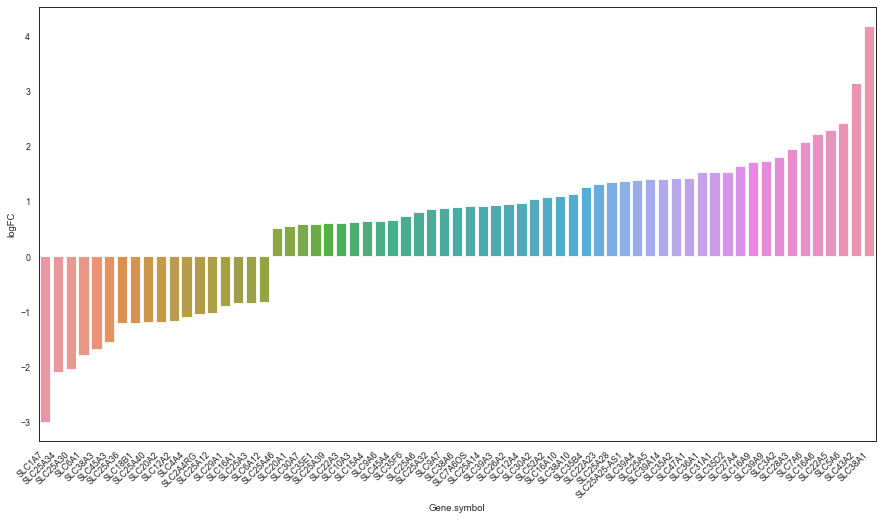

In [59]:
plt.figure(figsize = (15,8))
g = sns.barplot(data=SLC_sorted, x="Gene.symbol", y='logFC')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig('/Users/brooksleitner/Desktop/Python/sepsismetabolism/figures/rna/human_rna_SLC_barplot.svg', dpi=300, bbox_inches='tight')

# Genes Plots for Specific Pathways

In [60]:
muscle_rna_pathway_subsets = muscle_rna_pathway_subsets.rename(columns = {'Gene.symbol':'Genes'})

muscle_rna_pathway_subsets = muscle_rna_pathway_subsets.merge(human_muscle_gene_pathways, how='inner', on="Genes")

In [33]:
tca_df = muscle_rna_pathway_subsets[muscle_rna_pathway_subsets['Pathway'].str.contains('TCA')]
amino_df = muscle_rna_pathway_subsets[muscle_rna_pathway_subsets['Pathway'].str.contains('Amino')]
glutathione_df = muscle_rna_pathway_subsets[muscle_rna_pathway_subsets['Pathway'].str.contains('Glutathione')]
carbohydrate_df = muscle_rna_pathway_subsets[muscle_rna_pathway_subsets['Pathway'].str.contains('Carbohydrate')]
redox_df = muscle_rna_pathway_subsets[muscle_rna_pathway_subsets['Pathway'].str.contains('Redox')]
energy_df = muscle_rna_pathway_subsets[muscle_rna_pathway_subsets['Pathway'].str.contains('Energy')]


In [34]:
glutathione_df

,Genes,logFC,adj.P.Val,GSM333436,GSM333437,GSM333438,GSM333439,GSM333440,GSM333441,GSM333442,GSM333443,GSM333444,GSM333445,GSM333446,GSM333447,GSM333448,GSM333449,GSM333450,GSM333451,GSM333452,GSM333453,GSM333454,GSM333455,GSM333456,Pathway
5,GPX3,1.759709,0.000046,11.541505,11.586864,10.871133,11.806495,10.909089,11.808394,11.898933,11.889691,11.530957,10.983026,12.198222,12.294420,12.285686,10.566057,10.145925,9.355361,10.671384,9.820929,9.728719,9.195541,9.733439,Glutathione
20,MGST1,1.456816,0.000536,8.454906,7.349374,7.093426,7.498711,7.867752,7.971441,8.354748,8.227812,7.102725,7.204691,8.230002,8.644737,7.798602,7.034409,6.571078,6.047606,6.726515,5.279972,6.123829,6.907154,6.300404,Glutathione
25,ODC1,1.252559,0.000606,11.183116,10.347784,10.229449,11.525811,11.054226,10.778741,11.146413,10.621638,10.309003,10.325208,11.652537,10.511998,11.720449,9.870044,9.815414,9.839902,9.649425,9.081225,9.721746,9.809665,9.211414,Glutathione
58,MGST3,-1.229966,0.002109,10.733481,11.815235,11.017871,9.717818,9.315780,10.302209,10.521309,9.876271,9.878892,9.935574,10.869579,10.707346,10.001056,11.662688,11.697942,12.069111,11.574142,11.548309,11.599831,11.289937,11.285414,Glutathione
72,GSS,1.019014,0.003925,7.757000,7.486539,6.883460,6.964411,8.941978,6.862621,7.357045,7.735414,6.812354,7.128163,7.563177,7.369552,7.744693,6.441742,7.028865,6.492077,6.152082,6.395241,6.415910,6.154966,6.217099,Glutathione
74,IDH1,-0.867175,0.003944,8.079964,7.637702,7.419373,7.839315,6.615563,7.525195,7.812524,7.312491,7.115806,6.949460,8.097981,6.976869,7.310935,8.246263,7.964063,8.729685,8.502992,8.452544,8.287720,7.923877,8.333751,Glutathione
91,RRM1,0.771444,0.006985,9.020499,8.845840,8.391093,9.248202,9.109743,8.998830,9.030796,8.538165,8.973038,8.588448,9.562012,8.256813,9.094042,8.092732,8.657654,8.329747,8.422262,8.243015,8.125760,7.733853,7.397281,Glutathione
97,GSTA4,-0.822906,0.007957,8.662359,7.994940,8.329668,8.080328,7.604234,7.930807,8.003848,7.464405,7.933605,7.298618,8.431446,6.875114,8.351126,8.738731,8.583511,9.047658,8.825770,8.864658,8.930448,8.279862,8.672917,Glutathione
100,RRM2B,1.052735,0.008455,8.978255,8.310968,8.714810,9.649549,10.998768,9.042996,9.166730,9.751806,9.642721,8.671930,9.196098,9.174787,9.440837,8.314929,7.800221,8.499229,8.800880,8.295316,8.503055,7.636097,8.030092,Glutathione
109,LAP3,0.740945,0.010025,9.840973,9.951860,9.602938,10.390530,10.367349,9.731652,9.747450,9.272542,9.229043,9.488476,10.649013,9.862290,10.003233,9.133216,9.333817,9.416197,9.237915,9.350165,9.150889,8.603439,8.700559,Glutathione


In [37]:
redox_df

,Genes,logFC,adj.P.Val,GSM333436,GSM333437,GSM333438,GSM333439,GSM333440,GSM333441,GSM333442,GSM333443,GSM333444,GSM333445,GSM333446,GSM333447,GSM333448,GSM333449,GSM333450,GSM333451,GSM333452,GSM333453,GSM333454,GSM333455,GSM333456,Pathway
28,PRDX6,0.945383,0.000717,11.996427,11.056836,11.029959,12.339925,11.967436,12.000396,11.567039,11.647097,11.666227,11.510415,11.873424,11.428568,11.628986,10.442526,10.954915,10.871994,10.875736,10.855705,10.871617,10.428062,10.498068,Redox
38,NQO1,2.924496,0.001020,7.394589,6.338751,6.639180,5.957830,6.890822,4.724104,7.994615,7.584676,4.900335,4.490484,6.352051,3.584102,8.436741,4.021055,2.445540,3.535105,4.895136,2.629412,2.453859,3.266339,3.381145,Redox
39,ERP44,1.007792,0.001066,9.004972,8.417238,8.141915,9.090232,9.137072,8.166614,9.046969,8.657679,8.026960,8.151398,9.357004,8.450328,8.382517,7.609423,7.438752,7.870633,7.591664,7.797104,7.758637,7.584237,7.229309,Redox
46,TXNRD1,1.286195,0.001431,11.027677,9.423182,9.894792,10.221224,10.471868,9.684628,10.549969,9.939016,9.322458,9.031323,11.053248,9.709418,11.024814,8.857832,8.689037,8.990179,8.964932,8.922998,8.766192,8.575693,8.776576,Redox
57,GSR,1.311168,0.001841,7.848846,7.200864,6.814729,8.300671,8.048598,7.058916,8.352127,7.739185,6.252411,7.258590,8.428791,6.892664,7.793547,6.302213,6.335943,6.659120,6.131140,6.605055,5.892423,6.351869,5.534391,Redox
59,GLRX2,0.948297,0.002450,9.113135,9.467642,8.351923,9.379297,9.245326,8.646918,9.193451,9.268656,8.511801,8.316679,8.767063,8.660683,9.976068,7.961709,7.895265,7.873613,8.335956,7.928176,8.163505,8.318862,7.874166,Redox
66,ERO1A,0.981077,0.003448,7.256945,6.957006,6.569385,7.921926,7.393489,6.153912,7.585689,7.323383,6.670240,6.948355,7.758772,7.396580,7.201752,6.367288,6.113919,6.658163,5.642884,6.084197,6.429780,6.473613,5.696879,Redox
113,GCLC,0.739751,0.011205,8.556047,7.261614,7.555582,8.148652,7.737392,7.294957,7.723209,8.108940,7.039530,7.593650,8.328082,7.782039,7.828026,7.000362,7.016478,7.328762,7.560419,6.965770,6.574434,6.978437,6.785155,Redox
141,GLRX3,0.796034,0.015638,9.387404,8.770060,8.704138,10.046822,9.928306,8.631900,9.254809,9.210299,8.129797,8.547436,9.203756,8.937582,9.712585,8.348611,8.009747,8.632342,8.373382,8.413583,8.410065,8.211504,8.133967,Redox
152,APEX1,0.735750,0.018436,10.309192,9.534381,9.580177,10.033413,10.292383,9.940321,9.824215,9.422868,8.951731,9.255687,10.460668,8.957648,10.001614,8.906137,9.590644,9.043812,9.105545,8.972519,9.049631,8.573069,8.758367,Redox


In [38]:
energy_df

,Genes,logFC,adj.P.Val,GSM333436,GSM333437,GSM333438,GSM333439,GSM333440,GSM333441,GSM333442,GSM333443,GSM333444,GSM333445,GSM333446,GSM333447,GSM333448,GSM333449,GSM333450,GSM333451,GSM333452,GSM333453,GSM333454,GSM333455,GSM333456,Pathway
6,AHCYL1,1.601169,0.000084,9.759700,9.460968,8.835259,9.545069,9.912877,10.018907,9.811989,9.950063,8.830149,9.011959,9.516043,8.957922,10.791917,7.793272,8.056280,8.291957,8.041834,7.914216,8.342027,7.467403,7.839241,Energy
7,PRKAR1A,2.422242,0.000101,10.250244,8.706051,9.321106,10.294628,11.367187,9.555315,9.515929,11.059354,9.819243,8.079042,8.844667,9.622551,11.005805,7.391861,6.883680,7.535123,7.686649,7.415725,7.076741,7.561120,7.496473,Energy
30,PLCB1,-1.708347,0.000794,6.504895,7.457544,7.164691,5.579961,8.184973,6.794809,6.175007,6.981281,6.902206,7.196151,8.458486,7.074490,5.584382,8.681760,8.690002,8.537957,8.398130,8.955113,9.041340,8.522928,8.260390,Energy
36,ACLY,1.081872,0.000936,7.976458,7.626855,7.078578,7.904118,7.547087,7.887437,8.384945,8.038327,7.288059,7.547821,8.581553,8.083901,7.483980,7.055125,6.978237,6.823212,7.182948,6.293291,6.712930,6.681316,6.035882,Energy
37,TKT,2.195255,0.000944,7.016985,6.180117,4.587794,6.426790,6.721788,5.220151,6.058877,6.183716,5.457806,5.033615,6.901651,5.826643,6.452630,5.272580,3.755720,4.338285,3.306987,4.644071,4.479048,3.300332,1.383133,Energy
41,ACACB,1.653982,0.001199,10.454189,9.163168,9.212796,11.270051,9.725455,10.596609,9.732072,8.944772,9.488235,9.951795,9.401711,8.026998,8.363416,8.060100,7.732464,8.082074,8.074825,7.821980,7.825450,7.763688,7.919110,Energy
50,MARCKS,-1.313180,0.001538,5.699695,5.203399,6.623805,4.800654,5.636713,5.208837,5.342585,6.187830,5.782584,5.172472,6.264335,5.564490,7.064908,7.179909,7.205748,7.125034,7.462180,7.466326,6.968946,6.723805,6.251832,Energy
55,ACACA,1.810655,0.001731,7.754499,7.401278,7.194418,8.634726,9.041144,7.609753,8.402665,8.531719,7.808214,7.309517,8.384507,8.169388,6.847774,6.499353,5.492503,6.350263,7.728323,6.864811,5.964055,5.977822,4.077387,Energy
65,FASN,2.588527,0.003296,6.505162,6.411793,4.604507,8.804411,9.035463,7.988005,8.243482,6.398222,8.008023,6.542479,6.607241,5.112806,5.493905,4.608544,4.389445,2.204757,5.578779,4.496181,2.998702,5.122638,5.126889,Energy
76,SLC25A5,1.394041,0.004745,9.918398,9.326709,8.454701,9.407926,11.255220,10.439780,9.374716,9.308200,7.996388,8.367624,9.522417,9.662260,9.754958,8.375376,8.426088,8.243050,8.208416,7.987199,8.130397,7.701514,7.338273,Energy


In [61]:
tca_df

,Genes,logFC,adj.P.Val,GSM333436,GSM333437,GSM333438,GSM333439,GSM333440,GSM333441,GSM333442,GSM333443,GSM333444,GSM333445,GSM333446,GSM333447,GSM333448,GSM333449,GSM333450,GSM333451,GSM333452,GSM333453,GSM333454,GSM333455,GSM333456,Pathway
2,NDUFC1,-2.281624,0.000018,6.536177,7.262055,7.458156,6.726769,4.957202,6.223967,7.401411,6.549503,5.979333,6.155686,6.575618,5.780681,6.302896,8.318137,8.442210,9.362350,8.281766,9.379113,8.797168,9.034720,8.274114,TCA cycle
4,PDP1,-2.530489,0.000046,6.658028,8.217715,8.900810,9.608509,7.340535,7.146773,8.764276,7.584687,8.300610,8.330866,8.687585,7.083507,7.326271,10.472725,10.258813,10.946034,10.724215,11.179168,10.980992,9.584936,10.066367,TCA cycle
16,IDH3A,1.019339,0.000305,7.180704,6.441829,6.413121,7.097752,6.782855,7.053632,7.217985,6.544600,6.800395,6.265481,6.410350,6.896218,7.415434,5.634349,5.889959,5.592575,5.992064,6.080320,5.603958,5.686727,5.839398,TCA cycle
18,COQ10A,-2.039240,0.000349,8.819648,10.149085,8.749623,9.907406,6.915775,8.804836,9.317122,7.796985,8.747184,8.862352,9.164474,7.921001,7.591207,10.757693,10.780466,11.107002,10.897841,10.897071,10.952046,10.082847,10.221540,TCA cycle
61,SCO2,0.948652,0.002791,6.646866,6.644090,6.244640,7.093446,7.545310,6.703573,6.766443,6.806263,6.017607,6.949573,7.135266,7.317933,7.101493,5.757102,6.508009,5.415202,6.524363,5.976044,5.494548,5.718779,5.769045,TCA cycle
80,ACAD9,0.879045,0.005171,7.829557,7.698553,8.046000,8.685125,9.067451,7.904523,7.777414,8.097426,8.066719,7.380077,8.168931,7.334250,8.396047,7.413258,6.976236,7.301010,7.113068,7.486032,7.135555,6.553468,7.267214,TCA cycle
82,SLC16A1,-0.847020,0.005612,9.025546,8.553743,8.610506,8.455212,7.982924,8.202088,9.319160,8.392096,8.231477,7.984155,9.427168,8.562727,8.127247,9.140496,8.922651,9.729339,9.434098,9.510160,9.666332,9.197890,9.405377,TCA cycle
104,SURF1,0.732887,0.008935,9.736760,9.959174,9.343884,10.248438,10.727502,9.322375,9.807593,9.871022,10.000356,9.798857,9.667237,9.013403,9.905769,9.139122,8.986094,9.140323,9.226397,9.320612,8.993914,9.169832,8.562066,TCA cycle
106,SLC25A14,0.915306,0.009289,6.918977,6.107835,5.926043,7.246849,7.352821,6.129045,7.277947,6.745899,5.980347,6.386582,6.701159,6.421454,6.006930,4.779060,5.777657,6.093247,6.127782,5.526845,5.454466,5.960708,5.389724,TCA cycle
119,PDHA1,0.925284,0.012413,7.502431,7.119257,6.944396,7.627115,8.063494,8.237282,7.806662,7.690647,6.385344,6.321071,7.859948,7.239170,7.619652,6.180840,6.701189,6.895068,7.214521,6.472414,6.199948,6.061698,6.205265,TCA cycle


In [63]:
carbohydrate_df.head(50)

,Genes,logFC,adj.P.Val,GSM333436,GSM333437,GSM333438,GSM333439,GSM333440,GSM333441,GSM333442,GSM333443,GSM333444,GSM333445,GSM333446,GSM333447,GSM333448,GSM333449,GSM333450,GSM333451,GSM333452,GSM333453,GSM333454,GSM333455,GSM333456,Pathway
8,NUP88,1.371332,0.000103,9.762835,9.519268,9.439813,10.384669,10.888332,9.299364,9.857593,9.649706,9.351407,9.227336,10.060904,9.414304,10.258607,8.476571,8.460950,8.513417,8.422619,8.511540,8.196281,8.546239,8.125816,Carbohydrate
14,LUM,-2.447153,0.000277,6.072134,4.653019,7.286267,6.004620,4.733039,7.009714,6.433091,6.628141,6.053431,5.445581,5.300766,5.416615,7.216916,8.650438,9.188598,8.553477,10.106928,7.784388,7.692687,8.631261,7.125346,Carbohydrate
17,PFKP,2.533902,0.000348,8.620532,7.939939,7.224926,9.167974,11.441366,10.017190,8.850096,8.439247,9.858789,8.313995,9.278706,7.390549,9.701375,6.731244,6.915362,5.728040,6.899110,6.298573,6.587080,5.982430,6.122131,Carbohydrate
19,PGAM2,-2.505925,0.000487,10.067963,8.763837,10.395311,10.031879,7.375356,10.022803,9.877645,6.908082,9.519279,9.273206,10.269066,10.248446,7.712462,12.029264,11.411140,12.279536,11.399913,11.975264,12.299844,11.180297,11.604661,Carbohydrate
22,HK1,1.296432,0.000572,10.445879,10.021377,10.157684,10.456034,10.248498,9.349354,10.173751,11.168892,9.341260,9.596201,10.572862,9.938939,10.795180,9.342258,8.756783,8.909588,9.154146,9.195701,8.792673,8.680770,8.191029,Carbohydrate
23,SLC25A12,-1.034676,0.000597,8.305675,8.525071,8.431189,7.484863,7.359656,8.386640,8.507138,8.039280,7.827036,7.596462,8.275996,7.653818,7.990074,9.146592,9.001343,9.364305,8.921815,9.273255,9.291437,8.608753,8.905540,Carbohydrate
27,HS2ST1,1.702535,0.000640,6.509809,5.770744,5.862055,7.132843,6.924434,5.518202,6.403792,7.242797,5.719504,5.281689,6.189923,5.959229,7.343610,4.273133,4.891630,4.868200,5.001186,3.204206,5.346289,4.481522,4.688097,Carbohydrate
29,AGL,-1.368400,0.000747,9.979442,11.418461,11.674048,10.835849,9.239912,10.932798,10.939713,10.487628,10.634355,10.877254,10.506334,10.689228,10.176039,11.806703,12.149204,12.517983,12.087299,12.108743,12.323044,11.625762,11.492190,Carbohydrate
32,FBP2,-3.311119,0.000891,7.539387,9.760452,7.855040,6.586831,2.644594,8.734894,7.865414,6.080681,8.434953,6.469276,7.327976,8.373978,6.977385,11.349607,10.231910,11.135554,10.243217,10.114527,11.268131,9.614356,10.778333,Carbohydrate
33,HEXB,1.043634,0.000899,9.131345,9.084145,8.557835,9.519417,8.971914,8.606962,9.269346,8.989501,8.666972,8.823552,9.410473,8.053709,9.056543,7.783777,8.306987,7.646948,8.428360,7.959134,8.102819,7.285285,7.609443,Carbohydrate
